In [399]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import os
import pandas as pd

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [2]:
ROOT = os.getcwd()
ROOT

'c:\\Users\\dell-2019\\Desktop\\Sign Language Detection'

In [248]:
TOP = 100
BOTTOM = 300
RIGHT = 150
LEFT = 350

Testing the image contouring
[Code reference](https://stackoverflow.com/a/65794671/13280114)

In [545]:
def segment_hand_simple(img):
    # define the upper and lower boundaries of the HSV pixel intensities 
    # to be considered 'skin'
    
    hsvim = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    lower = np.array([0, 48, 80], dtype="uint8") 
    upper = np.array([20, 255, 255], dtype="uint8")
    skinMask= cv.inRange(hsvim, lower, upper)

    # blur the mask to help remove noise
    skinMask= cv.blur(skinMask, (2, 2))

    # get threshold image
    ret, thresh = cv.threshold(skinMask, 100, 255, cv.THRESH_BINARY)
    return thresh

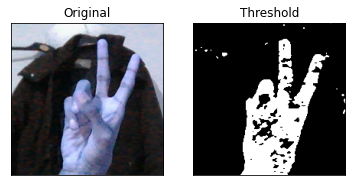

In [550]:
img_path = "images/train/f/0.png"
img = cv.imread(img_path)

thresh = segment_hand_simple(img)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(img)
ax[1].imshow(thresh)
ax[0].set_title("Original")
ax[1].set_title("Threshold")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])

plt.imshow(thresh, cmap='gray')

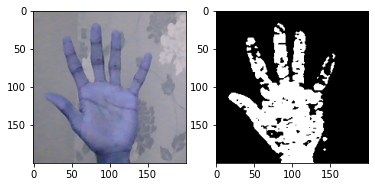

In [50]:
img_path = "images/train/0.png"
img = cv.imread(img_path)

thresh = segment_hand_simple(img)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(img)
ax[1].imshow(thresh)
plt.imshow(thresh, cmap='gray')

The ``generate_images()`` function is used to make augmented copies of the captured frame. This populates the dataset with a broad range of images to learn from.

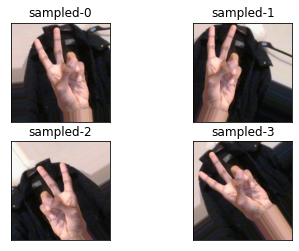

In [539]:
from keras.preprocessing import image

# generates transformed images for more data
def generate_images(img, prefix='sampled'):
    # creates a data generator object that transforms images
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.15,
        zoom_range=0.15,
        horizontal_flip=True,
        fill_mode='nearest')
    try:
        # pick an image to transform
        img = image.img_to_array(img)  # convert image to numpy array
        img = img.reshape((1,) + img.shape)  # reshape image
        i = 0
        # this loops runs forever until we break, saving images to current directory with specified prefix
        for batch in datagen.flow(img, save_prefix=prefix, save_format='png'):
            # plt.figure(i)
            # plot = plt.imshow(image.img_to_array(batch[0]))
            cv.imwrite(f'{prefix}-{i}.png', image.img_to_array(batch[0]))
            i += 1
            if i > 4:  # 4 images
                break
        plt.show()
    except Exception as e:
        print(f"[ERROR]  {e}")


'''
Example of how the images are generated
'''
# create a subplot of all the generated images
fig, ax = plt.subplots(2, 2)
images = [image.load_img(f'images/train/f/sampled-{i}.png') for i in range(4)]
for i, img in enumerate(images):
    ax[i // 2, i % 2].imshow(img)
    ax[i // 2, i % 2].set_xticks([])
    ax[i // 2, i % 2].set_yticks([])
    ax[i // 2, i % 2].set_title(f'sampled-{i}')

In [9]:
def chdir(path):
    if os.path.exists(f'images/{path}'):
        print('Directory changed to images')
    else:
        print('Directory not found')
        os.mkdir(f'images/{path}')
    os.chdir(f'images/{path}')

Here we begin collecting the images using OpenCV.<br>
Using the functions created above, we augument and segment the collected images.

In [445]:
# the letter of the hand
index = 'f'

In [504]:
# change directory to the folder where the images are
if os.getcwd() == ROOT:
    chdir(f"train/{index}")
else: 
    os.chdir(ROOT)
    chdir(f"train/{index}")

cam = cv.VideoCapture(0)
img_counter = 0

while True:
    ret, frame = cam.read()
    # filpping the frame to prevent inverted image of captured frame
    frame = cv.flip(frame, 1)
    
    if not ret:
        print("Please check if the camera is connected properly or is being used by another program")
        break

    
    # Drawing ROI on frame copy
    cv.imshow("Frame", frame)

    frame_copy = frame.copy()
    roi = frame[TOP:BOTTOM, RIGHT:LEFT]

    k = cv.waitKey(1)
    if k%256 == 27:
        break
    elif k%256 == 32: # SPACE pressed
        hand = roi#segment_hand_simple(roi)
        img_name = "{}.png".format(img_counter)
        path = os.getcwd() # get current working directory

        # save the image
        cv.imwrite(os.path.join(path , img_name), hand)

        # generate more images for the dataset
        generate_images(hand)

        # increment the image counter
        img_counter += 1

    # Display the frame with segmented hand
    cv.rectangle(frame_copy, (LEFT, TOP), (RIGHT, BOTTOM), (255,128,0), 3)

    cv.imshow("Hand Region", roi)

cam.release()
cv.destroyAllWindows()
# change directory to the root directory
os.chdir(ROOT)

Directory changed to images


Load the images using Keras ImageDataGenerator
<br>ImageDataGenerator is a high-level class that allows to yield data from multiple sources (from np arrays, from directories...) and that includes utility functions to perform image augmentation et cetera.

In [456]:
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

train_path = os.path.join(ROOT, "images/train")
test_path = os.path.join(ROOT, "images/test")

params = {
    'preprocessing_function': tf.keras.applications.vgg16.preprocess_input,
    'rescale':1./255,
    'shear_range':0.2,
    'zoom_range':0.2,
    'horizontal_flip':False,
}

train_batches = ImageDataGenerator(**params)

train_data = train_batches.flow_from_directory(
    directory=train_path, 
    target_size=(64,64), 
    class_mode='categorical', 
    batch_size=16,
    shuffle=True
)

Found 138 images belonging to 6 classes.


In [448]:
train_data.image_shape, train_data.class_indices

((64, 64, 3), {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5})

In [449]:
# create a dataframe from the batch data
df = pd.DataFrame()
df['image'] = train_data.filenames
df['image'] = df['image'].apply(lambda x: x.split('\\')[-1])
df['label'] = train_data.classes
df

,image,label
0,0.png,0
1,1.png,0
2,10.png,0
3,11.png,0
4,12.png,0
...,...,...
133,0.png-0.png,5
134,0.png-1.png,5
135,0.png-2.png,5
136,0.png-3.png,5


In [ ]:
# plot the images

# MODEL CREATION

In [450]:
from keras.models import Sequential
from tensorflow import keras
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, Activation
from tensorflow.keras.optimizers import SGD, Adam

In [464]:
INPUT_SHAPE = (64, 64, 3)
OUTPUT_SHAPE = train_data.num_classes

In [465]:
model_params = [
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=INPUT_SHAPE),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'valid'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(64,activation ="relu"),
    Dense(128,activation ="relu"),
    Dense(128,activation ="relu"),
    Dense(OUTPUT_SHAPE,activation ="softmax")
]

params = {
    'loss': 'categorical_crossentropy',
    'optimizer': Adam(learning_rate=0.001),
    'metrics': ['accuracy']
}

In [466]:
model = Sequential(model_params)

# compile the model with params
model.compile(**params)
model.summary()


Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_72 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_65 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_73 (Conv2D)          (None, 31, 31, 64)        18496     
                                                                 
 max_pooling2d_66 (MaxPoolin  (None, 15, 15, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_74 (Conv2D)          (None, 13, 13, 128)       73856     
                                                                 
 max_pooling2d_67 (MaxPoolin  (None, 6, 6, 128)      

NOTE: You need to install [Graphviz](https://graphviz.org/download/) and `pydot` for the following cell to run

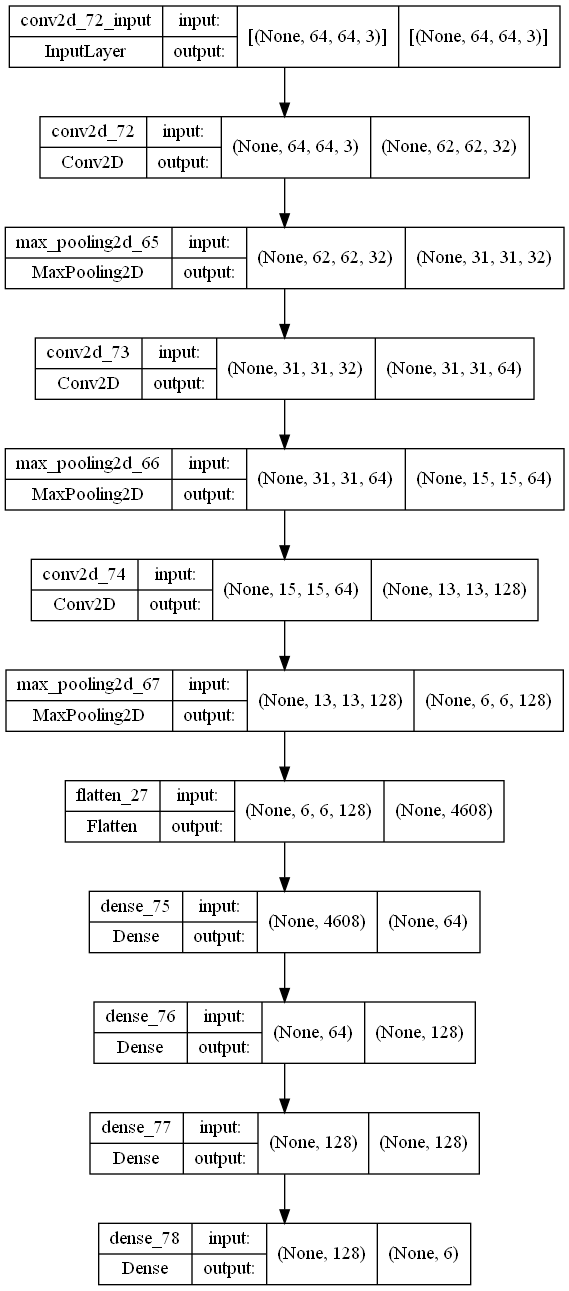

In [568]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [467]:
history = model.fit(train_data, epochs=20)

Epoch 1/20
9/9 [==============================] - 3s 120ms/step - loss: 1.6303 - accuracy: 0.2101
Epoch 2/20
9/9 [==============================] - 2s 172ms/step - loss: 1.1808 - accuracy: 0.6594
Epoch 3/20
9/9 [==============================] - 1s 136ms/step - loss: 0.7323 - accuracy: 0.7681
Epoch 4/20
9/9 [==============================] - 1s 119ms/step - loss: 0.4958 - accuracy: 0.7826
Epoch 5/20
9/9 [==============================] - 1s 141ms/step - loss: 0.4001 - accuracy: 0.8696
Epoch 6/20
9/9 [==============================] - 1s 126ms/step - loss: 0.3442 - accuracy: 0.9493
Epoch 7/20
9/9 [==============================] - 1s 116ms/step - loss: 0.2299 - accuracy: 0.9203
Epoch 8/20
9/9 [==============================] - 1s 129ms/step - loss: 0.1308 - accuracy: 0.9565
Epoch 9/20
9/9 [==============================] - 1s 122ms/step - loss: 0.0679 - accuracy: 0.9710
Epoch 10/20
9/9 [==============================] - 1s 129ms/step - loss: 0.0831 - accuracy: 0.9638
Epoch 11/20
9/9 [==

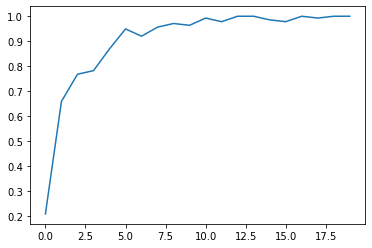

In [468]:
# plot the training loss and accuracy
plt.plot(history.history['accuracy'])

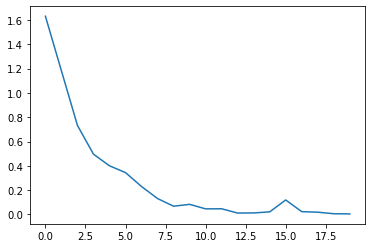

In [469]:
plt.plot(history.history['loss'])

In [491]:
# load the test data
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)
test_data = test_batches.flow_from_directory(
    directory=test_path,
    target_size=(64,64),
    class_mode='categorical',
    batch_size=3,
    shuffle=True
)

imgs, labels = next(test_data)

Found 61 images belonging to 6 classes.


In [492]:
scores = model.evaluate(imgs, labels, verbose=0)
print(f'{model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

loss of 0.0; accuracy of 100.0%


In [493]:
imgs[0].shape

(64, 64, 3)

In [494]:
try:
    predictions = model.predict(imgs)
    predictions
except Exception as e:
    print(e.__context__)

In [495]:
# loop through the test data and print the prediction and the actual label
for i in range(len(predictions)):
    print(f'Prediction: {predictions[i].argmax()}; Actual: {labels[i].argmax()}')


# plt.imshow(imgs[0])
# plt.title(f"{predictions[0].argmax()}-{labels[0].argmax()}")

Prediction: 1; Actual: 1
Prediction: 1; Actual: 1
Prediction: 5; Actual: 5


In [496]:
def make_predictions(model, test_batches):
    imgs, labels = next(test_batches)
    predictions = model.predict(imgs)
    return predictions, labels

def plot_predictions(predictions, labels):
    for i in range(len(predictions)):
        plt.imshow(imgs[i])
        plt.title(f"{predictions[i].argmax()}-{labels[i].argmax()}")
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


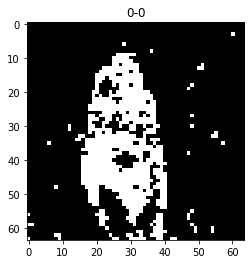

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


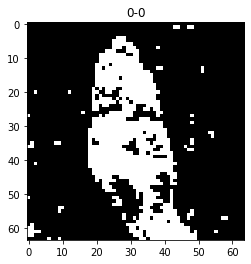

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


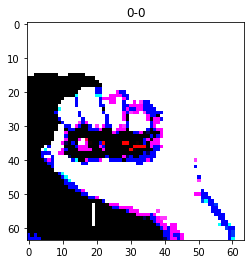

In [497]:
pred, true= make_predictions(model, test_data)

plot_predictions(pred, true)